# Identify the 25 hosptials with the highest (and lowest) hospital SHAP values (from a single XGBoost model)

This notebook defines the two sets of 25 hospitals to use as the benchmark hospitals in notebook 210.

## Plain English summary

Here we will use a single XGBoost model trained on all of the data (no test set) and use the SHAP values for each of the one-hot encoded hospital features that make up the *Stroke team* categorical feature, to identify the two sets of 25 "benchmark" hospitals (high and low) to use in the next set of notebooks that explore the effect on patient outcome by using different ways to decide which patient will receive thrombolysis.

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

## Model and data

Train XGBoost model on all of the data (no test set used) [reuse code from notebook https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb]. 

Population to train IVT decision model:
* Scanned within 4 hrs 15 mins of onset
* Just ischaemic
* Include thrombectomy patients

As we are only having patients with ischaemic we can remove this feature in the model: Infarction: Stroke type (1 = infarction, 0 = haemorrhage)

The 9 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

Calculate the SHAP values. 

Obtain SHAP values for just the onehot encoded features (reuse code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03b_xgb_all_data_shap_values_focus_on_ohe_hospitals.ipynb)

Identify the 25 hospitals with the highest SHAP values.

## Aims

* Using XGBoost model fitted on all the data (no test set) using 10 features
* Identify the 25 hospitals with the highest attended SHAP values

## Observations
The 25 hospitals with highest SHAP values (median) are:
* Queen's Medical Centre - Nottingham
* Luton and Dunstable Hospital
* Bronglais Hospital
* James Cook University Hospital
* Charing Cross Hospital HASU
* Queens Hospital Romford HASU
* Royal Berkshire Hospital
* Watford General Hospital
* Queen Alexandra Hospital Portsmouth
* John Radcliffe Hospital
* Southend Hospital
* Morriston Hospital
* University College Hospital HASU
* Royal London Hospital HASU
* Worthing Hospital
* Royal Victoria Infirmary
* University Hospitals of North Tees and Hartlepool
* Addenbrooke's Hospital
* Invicta Ward Kent and Canterbury Hospital
* Basildon University Hospital
* Queen Elizabeth Hospital Kings Lynn
* Northwick Park Hospital HASU
* Whiston Hospital HASU
* Leicester Royal Infirmary
* Ipswich Hospital

Use file in notebook 210: os.path.join(paths.data_save_path, (paths.notebook + paths.model_text + 'highest_25_benchmark_hospitals_median_shap.jpg'))

## Import libraries

In [368]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import machine learning methods
from xgboost import XGBClassifier

from os.path import exists

import shap

from scipy import stats

import os
import pickle
import json

from dataclasses import dataclass

# So can take deep copy
import copy

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from sklearn.metrics import confusion_matrix

import time

Report the time duration to run notebook

In [369]:
start_time = time.time()

In [370]:
surrogate_time_for_no_thrombolysis = 9999

In [371]:
k = 0

# Set up paths and filenames
Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [372]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    data_save_path: str = './saved_data'
    model_save_path: str = './saved_models'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_8_features_kfold_thrombolysis_decision'
    notebook: str = '200_'

paths = Paths()

Define the 9 features to use in the model

It's the 10 features minus Infarction, plus the target feature

In [373]:
input_features = ["prior_disability", "stroke_severity", 
                     "age", "arrival_to_scan_time", "precise_onset_known", 
                     "onset_to_arrival_time","onset_during_sleep", 
                     "stroke_team"]
target_feature = "S2Thrombolysis"

Create dictionary storing the feature names to use in the plots

In [374]:
dict_feature_names = {}
dict_feature_names["prior_disability"] = "Prior disability (mRS)"
dict_feature_names["stroke_severity"] = "Stroke severity (NIHSS)"
dict_feature_names["stroke_team"] = "Stroke team"
dict_feature_names["age"] = "Age (years)"
dict_feature_names["onset_to_arrival_time"] = "Onset to arrival time (minutes)"
dict_feature_names["arrival_to_scan_time"] = "Arrival to scan time (minutes)"
dict_feature_names["precise_onset_known"] = "Precise onset time known"
dict_feature_names['onset_during_sleep'] = "Stroke onset during sleep"
dict_feature_names['S2Thrombolysis'] = "Thrombolysis received"

## Create output folders if needed

In [375]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

Import data and select the features for this model.

Do not remove patients that had thrombectomy.

Create a new feature to use as the target feature: S2Thrombolysis (did patient receive thrombolysis?)


In [376]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train = pd.read_csv(filename)
# Create new feature "S2Thrombolysis" from the surrogate "scan_to_thrombolysis_time"
train["S2Thrombolysis"] = (train["scan_to_thrombolysis_time"] > -100) * 1
# Keep columns for model
train = train[input_features + [target_feature]]

filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test = pd.read_csv(filename)
# Create new feature "S2Thrombolysis" from the surrogate "scan_to_thrombolysis_time"
test["S2Thrombolysis"] = (test["scan_to_thrombolysis_time"] > -100) * 1
# Keep columns for model
test = test[input_features + [target_feature]]

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [377]:
X_train = train[input_features]
y_train = train[target_feature]
X_test = test[input_features]
y_test = test[target_feature]

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [378]:
print (f'Average treatment: {round(y_train.mean(),2)}')

Average treatment: 0.44


### One-hot encode hospital feature

In [379]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

In [380]:
X_train = (convert_feature_to_one_hot(X_train, "stroke_team", "team"))
X_test = (convert_feature_to_one_hot(X_test, "stroke_team", "team"))

### Get model feature names 
With one-hot encoded hospitals

In [381]:
feature_names_ohe = list(X_train.columns)

In [382]:
print(f"There are {len(input_features)} original features "
      f"(before one-hot encoding)")
print(f"There are {len(feature_names_ohe)} features (after one-hot encoding)")

There are 8 original features (before one-hot encoding)
There are 118 features (after one-hot encoding)


## XGBoost model

Train an XGBoost model on the full dataset (rather than train/test splits used to assess accuracy).

In [383]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                (paths.notebook + paths.model_text + '.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:
    # Define and Fit model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
    model.fit(X_train, y_train)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)

# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Calculate the models accuracy
accuracy = np.mean(y_test == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

# Calculate ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

print (f'ROC AUC: {roc_auc:0.4f}')


Model accuracy: 0.787
ROC AUC: 0.8617


Calculate data for sensitivity-specificity curve:

In [384]:

def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

In [385]:
# Set up list for accuracy measures
sensitivity = []
specificity = []

# Loop through increments in probability of survival
thresholds = np.arange(0.0, 1.01, 0.01)
for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
    # Get classificiation using cutoff
    predicted_class = y_pred_proba[:,1] >= cutoff
    predicted_class = predicted_class * 1.0
    # Call accuracy measures function
    accuracy = calculate_accuracy(y_test, predicted_class)
    # Add accuracy scores to lists
    sensitivity.append(accuracy['sensitivity'])
    specificity.append(accuracy['specificity'])

Create a combined plot: ROC and sensitivity-specificity.

(Identify cross-over point on sensitivity-specificity curve: Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients not receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.)

In [386]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and 
    b2,b1.
    
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [387]:
sens = np.array(sensitivity)
spec = np.array(specificity)
df = pd.DataFrame()
df['sensitivity'] = sens
df['specificity'] = spec
df['spec greater sens'] = spec > sens

# find last index for senitivity being greater than specificity 
mask = df['spec greater sens'] == False
last_id_sens_greater_spec = np.max(df[mask].index)
locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
points = df.iloc[locs][['sensitivity', 'specificity']]

# Get intersetction with line of x=y
a1 = list(points.iloc[0].values)
a2 = list(points.iloc[1].values)
b1 = [0, 0]
b2 = [1, 1]

intersection = get_intersect(a1, a2, b1, b2)[0]

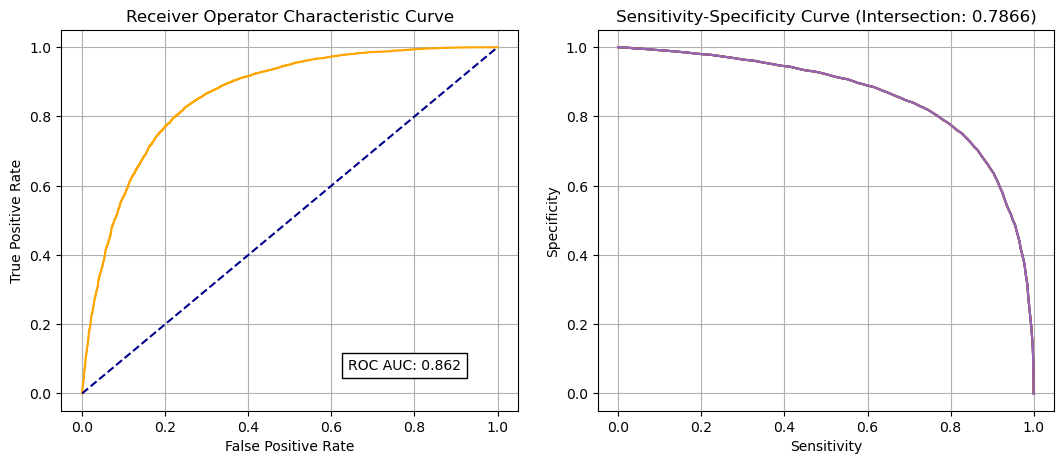

In [388]:
fig = plt.figure(figsize=(11,5))

# Plot ROC
ax1 = fig.add_subplot(121)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'ROC AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for k in range(5):
    ax2.plot(sensitivity, specificity)
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title(f'Sensitivity-Specificity Curve (Intersection: {intersection:0.4f})')
plt.grid(True)


plt.tight_layout(pad=2)
filename = os.path.join(paths.image_save_path, 
                (paths.notebook + paths.model_text + '_roc_sens_spec.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

Confusion matrix

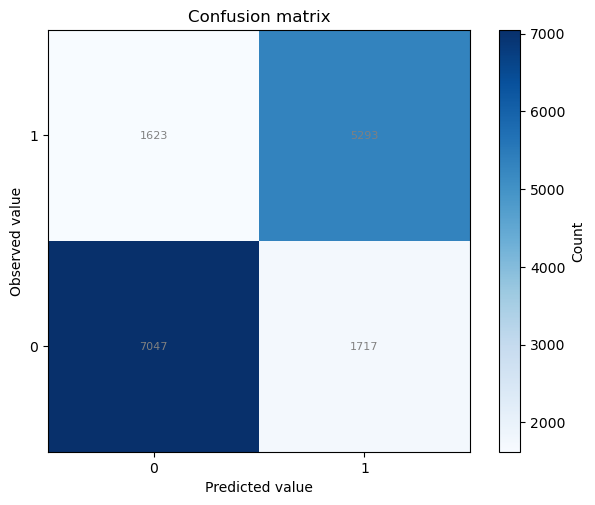

In [389]:
fig, ax = plt.subplots()

# Legend height
shrink = 1

# Set axis title
ax.set_title('Confusion matrix')

# Calculate values for confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix with colors
heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

# Add values to plot
for i in range(len(cm)):
    for j in range(len(cm[0])):
        ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                size=8)

# Set axis titles
ax.set_xlabel('Predicted value')
ax.set_ylabel('Observed value')
ax.set_xticks([0,1])
ax.set_yticks([0,1])

plt.tight_layout()

# Make space for title
plt.subplots_adjust(top=1)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_confusion_matrix.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

# SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

## Get SHAP values
TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Once set up, we can use this explainer to calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

Setup method to estimate SHAP values (in their default units: log odds)

In [390]:
# SHAP filename
filename_shap_explainer = os.path.join(paths.data_save_path, 
                (paths.notebook + paths.model_text + '_shap_explainer.p'))

# Check if exists
file_exists = exists(filename_shap_explainer)

if file_exists:
    # Load SHAP explainer
    with open(filename_shap_explainer, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename_shap_explainer, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

Calculate SHAP values extended

In [391]:
# SHAP filename
filename_shap_extended = os.path.join(paths.data_save_path, 
                (paths.notebook + paths.model_text + '_shap_values_extended.p'))

file_exists = exists(filename_shap_extended)

if file_exists:
    # Load explainer
    with open(filename_shap_extended, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values_extended = explainer(X_test)
    
    # Save using pickle
    with open(filename_shap_extended, 'wb') as filehandler:
        pickle.dump(shap_values_extended, filehandler)

The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [392]:
shap_values_extended[0]

.values =
array([ 6.25320435e-01,  1.16969311e+00,  1.15617387e-01,  8.88965949e-02,
        4.36284631e-01,  2.33375043e-01,  4.26341072e-02,  2.74342229e-03,
       -7.94313382e-03,  2.75008730e-03,  3.57081275e-03,  1.31405377e+00,
       -5.57288202e-03, -8.28802958e-03,  2.18132883e-03, -2.62246071e-03,
       -6.85829669e-04,  1.68083305e-03,  8.18243832e-04,  2.21818569e-03,
        2.58734915e-03,  2.58529442e-03,  7.84177613e-03,  1.14865892e-03,
       -9.15040448e-03, -2.21264106e-03,  1.76117430e-03, -3.55664268e-03,
        1.99851184e-03, -1.88239355e-04,  1.19249546e-03,  8.23947368e-04,
       -2.24938542e-02,  1.87044695e-03, -1.29626878e-03,  2.52640108e-04,
        4.15919721e-03, -5.48373815e-03, -3.46536725e-03, -1.75333960e-04,
       -2.69419909e-03, -9.08089802e-04,  2.92616838e-04, -2.97763414e-04,
       -1.91139476e-03,  1.91610525e-04,  2.64321454e-03,  3.23448726e-03,
       -7.60591030e-03, -4.05166298e-03,  2.30234175e-04,  7.22097373e-03,
        1.18989

There is one of these for each instance.

In [393]:
shap_values_extended.shape

(15680, 118)

### Understand SHAP values for the one-hot encoded hospital features 

We've seen above that the categorical feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features.

For the hospital that the instance attends, the SHAP value for that hosptial represents "the contribution to the prediction due to attending this hospital". For all of the other hosptials for this instance, the SHAP value for those hospitals represents "the contribution to the prediction from not attending this hospital". 

Here we will focus on understanding the SHAP values for each hospital, their contribution when a patient attends the hospital, and the contribution when the patient does not attend the hospital.

#### Format the data 

Features are in the same order in shap_values as they are in the original dataset.

Use this to extract the SHAP values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

In [394]:
# Get list of one-hot encoded hospital column titles
hospital_names_ohe = X_test.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names_ohe_wo_prefix = [int(h[5:]) for h in hospital_names_ohe]

# Create list of column indices for these hospital column titles (where do the
#   hospital features exist in the datasets?)
hospital_columns_index = [X_test.columns.get_loc(col) for col in hospital_names_ohe]
# Use this index list to access the hosptial shap values (as array)
hosp_shap_values = shap_values_extended.values[:,hospital_columns_index]
# Put in dataframe with hospital as column title
df_hosp_shap_values = pd.DataFrame(hosp_shap_values, columns = hospital_names_ohe_wo_prefix)

Also include four further columns:
1) contribution from all of the one-hot encoded hospital features
2) the hospital that the instance attended
3) contribution from just the hospital attended
4) contribution from not attending the rest

In [395]:
# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_values["all_stroke_teams"] = df_hosp_shap_values.sum(axis=1)

# Include Stroke team that each instance attended
df_hosp_shap_values["stroke_team"] = test["stroke_team"].values

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_attended_hospital = []
shap_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_values.iterrows():

    # Get stroke team attended
    stroke_team_attended = row["stroke_team"]
    stroke_team_attended_shap = row[int(stroke_team_attended)]
    # Get SHAP value for the stroke team attended
    shap_attended_hospital.append(stroke_team_attended_shap)

    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - stroke_team_attended_shap
    shap_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_values["attended_stroke_team"] = shap_attended_hospital
df_hosp_shap_values["not_attended_stroke_teams"] = (
                                            shap_not_attend_these_hospitals)
                   
# View preview
df_hosp_shap_values.head()

,1,2,3,4,6,7,8,10,11,12,...,112,113,114,116,117,118,all_stroke_teams,stroke_team,attended_stroke_team,not_attended_stroke_teams
0,0.002743,-0.007943,0.002750,0.003571,1.314054,-0.005573,-0.008288,0.002181,-0.002622,-0.000686,...,0.000160,0.004042,0.002477,-0.002312,0.000125,-0.002590,1.244874,6,1.314054,-0.069180
1,0.009318,-0.009988,0.003612,0.012593,-0.011185,-0.004170,-0.007260,0.001005,-0.003936,-0.000781,...,0.000077,0.003948,0.002885,-0.002390,0.003022,-0.000602,-0.184609,70,-0.105269,-0.079340
2,0.010111,-0.009689,0.006454,0.007468,-0.013180,-0.007229,-0.007337,-0.000609,-0.001036,-0.006014,...,0.000396,0.003533,0.004331,-0.002280,0.001251,-0.001349,0.362709,33,0.369268,-0.006559
3,0.010363,-0.005479,0.004635,0.000076,-0.015305,-0.010820,-0.017199,0.000998,-0.004456,-0.001555,...,-0.000019,0.004011,0.005890,-0.000530,0.000765,-0.000679,-0.114876,40,-0.061369,-0.053507
4,0.007471,-0.007314,0.006722,0.004788,-0.011990,-0.007688,-0.010586,0.000556,-0.002647,-0.010514,...,-0.000122,0.002782,0.005958,-0.000530,0.001251,-0.002037,-0.589910,16,-0.564657,-0.025253


#### Boxplot (all hospitals together)

Analyse the range of SHAP values for the one-hot encoded hospital features. Show as two populations: 1) the attended hospital, 2) the sum of the hospitals not attended

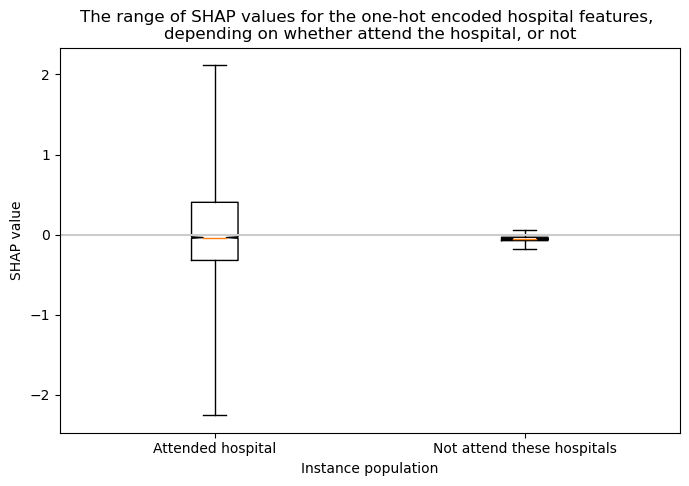

In [396]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.boxplot([shap_attended_hospital, shap_not_attend_these_hospitals],
            labels=["Attended hospital", "Not attend these hospitals"],
            whis=99999, notch=True);
title = ("The range of SHAP values for the one-hot encoded hospital features, "
         "\ndepending on whether attend the hospital, or not")

# Add line at Shap = 0
ax.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
ax.set_title(title)
ax.set_xlabel("Instance population")
ax.set_ylabel("SHAP value");

filename = os.path.join(paths.image_save_path, 
    (paths.notebook + paths.model_text + 'hosp_shap_attend_vs_notattend_boxplot.jpg'))

plt.savefig(filename, dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Boxplot (individual hospitals)

Create a boxplot to show the range of SHAP values for each individual one-hot encoded hospital feature. 

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of mean SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the mean SHAP value for each hosptial (for those instances that attended the hospital)

In [397]:
# Initialise lists
attend_stroketeam_min = []
attend_stroketeam_q1 = []
attend_stroketeam_mean = []
attend_stroketeam_median = []
attend_stroketeam_q3 = []
attend_stroketeam_max = []

# For each hospital, store descriptive statistics of SHAP values for those
#   instances that attend the hospital
for h in hospital_names_ohe_wo_prefix:
    mask = df_hosp_shap_values['stroke_team'] == int(h)
    data_stroke_team = df_hosp_shap_values[h][mask]
    q1, q3 = np.percentile(data_stroke_team, [25,75])
    attend_stroketeam_min.append(data_stroke_team.min())
    attend_stroketeam_q1.append(q1)
    attend_stroketeam_mean.append(data_stroke_team.mean())
    attend_stroketeam_median.append(data_stroke_team.median())
    attend_stroketeam_q3.append(q3)
    attend_stroketeam_max.append(data_stroke_team.max())
    
# Create dataframe with 6 columns
df_hosp_shap_value_stats = pd.DataFrame(hospital_names_ohe_wo_prefix, columns=["stroke_team"])
df_hosp_shap_value_stats["shap_min"] = attend_stroketeam_min
df_hosp_shap_value_stats["shap_q1"] = attend_stroketeam_q1
df_hosp_shap_value_stats["shap_mean"] = attend_stroketeam_mean
df_hosp_shap_value_stats["shap_median"] = attend_stroketeam_median
df_hosp_shap_value_stats["shap_q3"] = attend_stroketeam_q3
df_hosp_shap_value_stats["shap_max"] = attend_stroketeam_max

# sort in descending mean SHAP value order
df_hosp_shap_value_stats.sort_values("shap_median", ascending=False, inplace=True)  

# show the 25 hospitals with highest SHAP values (mean of all the attended patients)
df_hosp_shap_value_stats.head(25)

,stroke_team,shap_min,shap_q1,shap_mean,shap_median,shap_q3,shap_max
25,28,0.509756,0.945497,1.120200,1.112737,1.255745,1.874360
55,61,0.330311,0.922149,1.063335,1.082315,1.213336,1.674355
57,63,0.471544,0.853710,1.025420,1.032884,1.200168,1.675918
58,64,-0.032663,0.794559,0.975112,0.996659,1.151161,1.860119
4,6,0.432591,0.873635,1.012062,0.994733,1.193451,1.593634
6,8,0.091208,0.769822,0.970088,0.933694,1.212195,2.114887
73,80,0.084551,0.721240,0.910458,0.867378,1.103518,1.864613
100,107,0.076787,0.686298,0.801541,0.798008,0.889527,1.947474
1,2,-0.325748,0.616814,0.786092,0.796317,0.975631,1.537791
88,95,0.222727,0.610887,0.801809,0.780474,0.981001,1.856647


[Text(0.5, 0, 'SHAP mean'), Text(0, 0.5, 'SHAP median')]

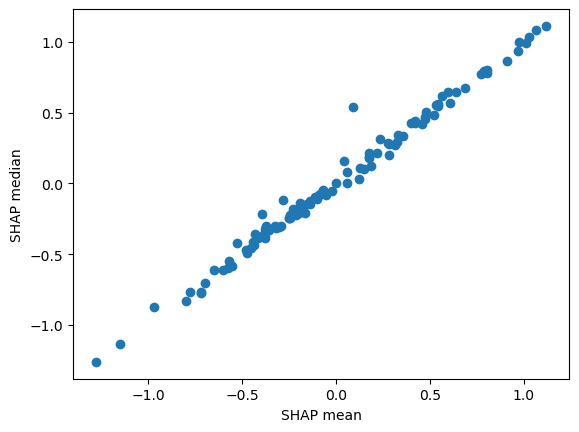

In [398]:
# sort in descending mean SHAP value order
plt.scatter(df_hosp_shap_value_stats["shap_mean"], df_hosp_shap_value_stats["shap_median"])
plt.gca().update(dict(xlabel="SHAP mean",ylabel="SHAP median"))

Print out the ranked list of hosptials names to use in notebook 210

In [399]:
filename = os.path.join(paths.data_save_path, 
    (paths.notebook + paths.model_text + '_ranked_hospitals_median_shap.csv'))

df_hosp_shap_value_stats.to_csv(filename)

Add admission figures to xlabel in boxplot

Create dataframe with admissions and thrombolysis rate per stroke team (index)

In [400]:
# Get Stroke team name, the stroke team admission numbers, and list of SHAP 
#   values for each instance that attended teh stroke team
unique_stroketeams_list = list(set(train["stroke_team"]))
admissions = [X_train[f'team_{s}'].sum() for s in unique_stroketeams_list]

df_stroketeam_ivt_adms = pd.DataFrame(unique_stroketeams_list, 
                                      columns=["stroke_team"])
df_stroketeam_ivt_adms["Admissions"] = admissions
df_stroketeam_ivt_adms.set_index("stroke_team", inplace=True)
df_stroketeam_ivt_adms.sort_values("Admissions", ascending=True, inplace=True)

# Calculate IVT rate per hosptial
hosp_ivt_rate = train.groupby(by=["stroke_team"]).mean()["S2Thrombolysis"]

# Join IVT rate with admissions per hosptial
df_stroketeam_ivt_adms = df_stroketeam_ivt_adms.join(hosp_ivt_rate)

df_stroketeam_ivt_adms

,Admissions,S2Thrombolysis
stroke_team,,
48,212,0.363208
118,228,0.578947
112,234,0.350427
61,236,0.521186
52,254,0.433071
...,...,...
28,970,0.678351
67,1002,0.391218
96,1047,0.430755


In [401]:
# Go through this order of hospitals
hospital_order = df_hosp_shap_value_stats["stroke_team"].values
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
attend_stroketeam_groups_ordered = []
not_attend_stroketeam_groups_ordered = []

# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
h = hospital_order[0]
# Attend
mask = df_hosp_shap_values['stroke_team'] == int(h)
attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
# Not attend
mask = df_hosp_shap_values['stroke_team'] != h
not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
# Label
ivt_rate = int(df_stroketeam_ivt_adms['S2Thrombolysis'].loc[int(h)] * 100)
xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[int(h)]}, "
                f"{ivt_rate}%)")

Create data for boxplot. Using order of hospitals from the hosp_shap_stats_df dataframe.

In [402]:
# Go through this order of hospitals
hospital_order = df_hosp_shap_value_stats["stroke_team"].values
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
attend_stroketeam_groups_ordered = []
not_attend_stroketeam_groups_ordered = []

# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_values['stroke_team'] == int(h)
    attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Not attend
    mask = df_hosp_shap_values['stroke_team'] != int(h)
    not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Label
    ivt_rate = int(df_stroketeam_ivt_adms['S2Thrombolysis'].loc[int(h)] * 100)
    xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[int(h)]}, "
                  f"{ivt_rate}%)")

Plot the boxplot

Resource for using overall y min and max of both datasets on the 4 plots so have the same range: https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists

Shows the range of contributions to the prediction from this hospital when patients 1) do [black], and 2) do not [orange] attend this hospital


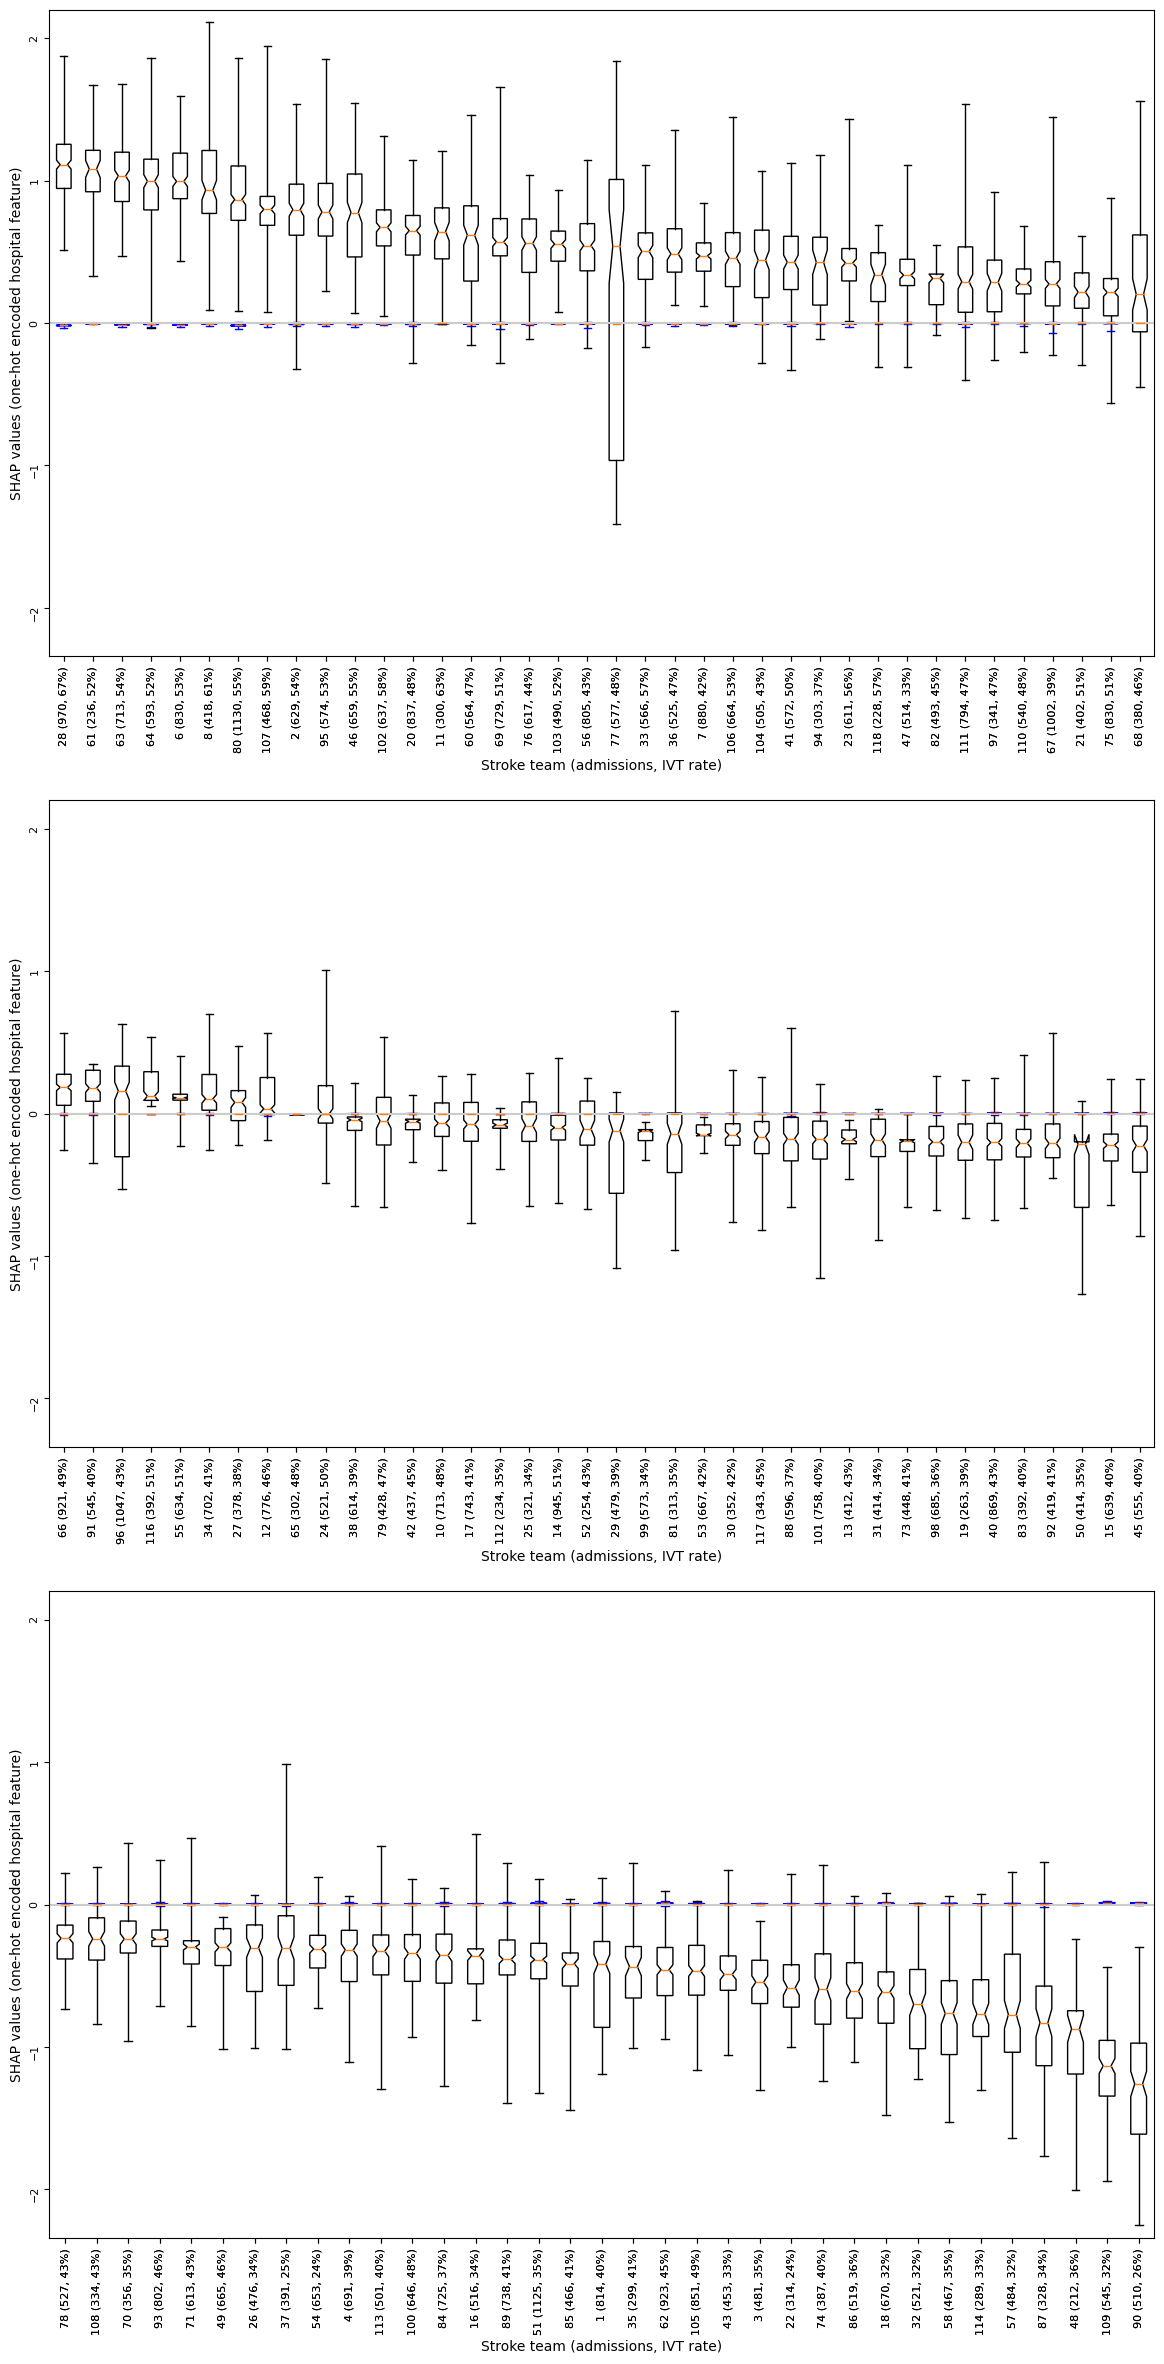

In [403]:
# Plot 34 hospitals on each figure to aid readability
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this "
      "hospital")

# Group the hospitals into 3 subplots
n_subplots = 3
st = 0
ed = round((n_hospitals/n_subplots)+1)
inc = ed
max_size = n_hospitals

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin1 = min(min(attend_stroketeam_groups_ordered, key=min))
ymin2 = min(min(not_attend_stroketeam_groups_ordered, key=min))
ymax1 = max(max(attend_stroketeam_groups_ordered, key=max))
ymax2 = max(max(not_attend_stroketeam_groups_ordered, key=max))
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin1
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,8*n_subplots))

# colours for the boxplots
c1 = "blue"
c2 = "blue"
c3 = "white"
c4 = "black"
c5 = "black"
c6 = "white"

# Create four subplots
for subplot in range(n_subplots):
    ax = fig.add_subplot(n_subplots,1,subplot+1)

    # The contribution from this hospital when patients don't attend this 
    #    hospital
    ax.boxplot(not_attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],
               whis=99999, patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))
       
    # The contribution from this hospital when patients do attend this hosptial
    ax.boxplot(attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],
               whis=99999, patch_artist=True, notch=True,
               boxprops=dict(facecolor=c6, color=c4),
               capprops=dict(color=c4),
               whiskerprops=dict(color=c4),
               flierprops=dict(color=c4, markeredgecolor=c4),
               meanprops=dict(color=c5))

    plt.gca().update(dict(xlabel='Stroke team (admissions, IVT rate)',
                          ylabel='SHAP values (one-hot encoded hospital feature)',
                          ))
    
    ax.tick_params(axis='both', labelsize=8, rotation=90)
#    plt.labelsize=12
#    plt.xticksrotation=90                          
    plt.ylim(ymin, ymax)    
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

plt.subplots_adjust(bottom=0.25, wspace=0.05)
    
plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
    (paths.notebook + paths.model_text + 'individual_hosp_shap_attend_vs_notattend_boxplot.jpg'))

plt.savefig(filename, dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

Notice that when patients do not attend the hospital, the range of the SHAP values are largely centred on zero.
When patients do attend hosptial, the range of SHAP values are largely on one side of zero, or the other.

In [404]:
iqr_below_zero = df_hosp_shap_value_stats["shap_q3"] < 0
iqr_spans_zero = (df_hosp_shap_value_stats["shap_q1"] * 
                  df_hosp_shap_value_stats["shap_q3"])
iqr_above_zero = df_hosp_shap_value_stats["shap_q1"] > 0
iqr_is_zero1 = df_hosp_shap_value_stats["shap_q1"] == 0
iqr_is_zero2 = df_hosp_shap_value_stats["shap_q3"] == 0
iqr_is_zero = iqr_is_zero1 * iqr_is_zero2

print (f"There are {iqr_below_zero.sum()} hospitals whose interquartile range "
       f"is below zero")
print (f"There are {iqr_spans_zero.lt(0).sum()} hospitals whose interquartile "
       f"range spans zero")
print (f"There are {iqr_above_zero.sum()} hospitals whose interquartile range "
       f"is above zero")
print (f"There are {iqr_is_zero.sum()} hospitals whose interquartile range is "
       f"zero")

There are 56 hospitals whose interquartile range is below zero
There are 13 hospitals whose interquartile range spans zero
There are 41 hospitals whose interquartile range is above zero
There are 1 hospitals whose interquartile range is zero


How does the SHAP value for the attended one-hot encoded hospital feature compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and SHAP value (for those patients that attend the hospital).

In [405]:
df_hosp_plot = (
        df_hosp_shap_value_stats[["shap_median","stroke_team"]].copy(deep=True))
df_hosp_plot["stroke_team"] = df_hosp_plot["stroke_team"].astype(int)
df_hosp_plot.set_index("stroke_team", inplace=True)
df_hosp_plot = df_hosp_plot.join(hosp_ivt_rate)
df_hosp_plot

,shap_median,S2Thrombolysis
stroke_team,,
28,1.112737,0.678351
61,1.082315,0.521186
63,1.032884,0.541374
64,0.996659,0.526138
6,0.994733,0.532530
...,...,...
57,-0.772816,0.324380
87,-0.830061,0.344512
48,-0.873247,0.363208


Plot SHAP value for one-hot encoded hospital feature (mean for those instances that attend the hospital) vs hospital IVT rate

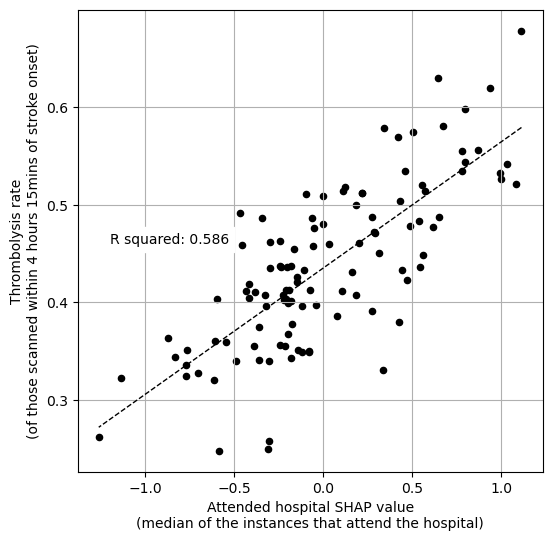

In [406]:
# Setup data for chart
x = df_hosp_plot['shap_median']
y = df_hosp_plot['S2Thrombolysis']

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x, y, color='black', marker='o', s=20)
ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

# Set chart limits
#ax.set_ylim(0, 0.5)
#ax.set_xlim(-1.5, 1.5)

# Add textbox
text = f'R squared: {r_square:.3f}'
ax.text(-1.2, 0.46, text, 
         bbox=dict(facecolor='white', edgecolor='white'))

# Chart titles
ax.set_xlabel("Attended hospital SHAP value"
              "\n(median of the instances that attend the hospital)")
ax.set_ylabel('Thrombolysis rate\n(of those scanned within 4 hours 15mins of '
              'stroke onset)')
plt.grid()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         'attended_hosp_shap_vs_ivt_rate.jpg'))

plt.savefig(filename, dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

In [407]:
f = ('formula: ' + str("{:.2f}".format(slope)) + 'x + ' + 
     str("{:.2f}".format(intercept)))
print (f'R squared: {r_square:.3f}\np: {p_value:0.4f}\nformula: {f}')

R squared: 0.586
p: 0.0000
formula: formula: 0.13x + 0.44
